In [ ]:
'''
This notebook generates the figures for melanoma dataset.
 - Figure 5. The confusion matrix of the melanoma dataset for the unknown cell-type identification task. 
     SigPrimedNet (top) and Scibet (bottom).
 - Figure 6. Similarity score distribution per cell type on the validation and test splits (Melanoma dataset).
'''

In [1]:
#!/usr/bin/env python

# importing default libraries
import os
import sys
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
os.chdir(ROOT_DIR)
sys.path.append(ROOT_DIR)
# importing scripts in scripts folder
from scripts import config as src
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

**** scripts/config.py IMPORTED!!!
**** PROJECT FOLDER ,  /home/pgundogdu/projects/signalization_prior_knowledge_based_nn


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')
import glob
FIGURE_TITLE_SIZE = 18
SUBPLOT_TITLE_SIZE = 14
LEGEND_TITLE_SIZE = 12
FONT_SIZE = 10

plt.rc('font', size=16) # controls default text sizes
plt.rc('axes', titlesize=SUBPLOT_TITLE_SIZE) # fontsize of the axes title
plt.rc('axes', labelsize=LEGEND_TITLE_SIZE) # fontsize of the x and y labels
plt.rc('xtick', labelsize=LEGEND_TITLE_SIZE) # fontsize of the tick labels
plt.rc('ytick', labelsize=LEGEND_TITLE_SIZE) # fontsize of the tick labels
plt.rc('legend', fontsize=FONT_SIZE) # legend fontsize
plt.rc('legend', title_fontsize=SUBPLOT_TITLE_SIZE) # legend fontsize
plt.rc('figure', titlesize=FIGURE_TITLE_SIZE) # fontsize of the figure title

In [3]:
from sklearn.neighbors import LocalOutlierFactor
def calculate_threshold(encoding_with_seen, encoding_with_unseen, y_with_seen, y_with_unseen):
    lof = LocalOutlierFactor(novelty=True)
    lof.fit(encoding_with_seen)

    df_score_unseen = pd.concat([ y_with_unseen, pd.DataFrame(lof.score_samples(encoding_with_unseen), columns=['score'])], axis=1)
    df_score_seen = pd.concat([ y_with_seen, pd.DataFrame(lof.score_samples(encoding_with_seen), columns=['score'])], axis=1)

    # Calculated threshold value
    threshold = np.mean(df_score_seen.groupby('cell_type').aggregate(['mean', 'std'])['score']['mean'] 
                        - 1*df_score_seen.groupby('cell_type').aggregate(['mean', 'std'])['score']['std'])
    print('Threshold value from reference dataset, ', threshold)
    return threshold, df_score_seen, df_score_unseen

## MELANOMA

In [4]:
# loading dataset
loc_output = './reports/retrieval_lof/exper_melanoma'

df_query = pd.read_pickle('./data/processed/exper_melanoma/query_log1p.pck')
df_reference = pd.read_pickle('./data/processed/exper_melanoma/reference_log1p.pck')

X_query = df_query.iloc[:, :-1].values
y_ground_truth_query = df_query.iloc[:, -1:]

X_reference = df_reference.iloc[:, :-1].values
y_ground_truth_reference = df_reference.iloc[:, -1:]

ohe = OneHotEncoder()
y_ohe = ohe.fit_transform(y_ground_truth_reference.values).toarray()
X_train, X_test, y_train, y_test = train_test_split(X_reference, y_ground_truth_reference, test_size=0.3, random_state=91, stratify=y_ohe)

In [5]:
# the order of the legend of the plot
order_plot = list(np.unique(y_ground_truth_reference))
seen_label = dict(zip(order_plot, range(len(order_plot))))
order_plot.append('Neg.cell')
unseen_label = dict(zip(order_plot, range(len(order_plot))))
print(seen_label)
print(unseen_label)

{'B.cell': 0, 'Macrophage': 1, 'NK': 2, 'T.CD4': 3, 'T.CD8': 4}
{'B.cell': 0, 'Macrophage': 1, 'NK': 2, 'T.CD4': 3, 'T.CD8': 4, 'Neg.cell': 5}


## LOADING MODEL

In [6]:
# loading 1-layer design
model_name = 'circuits_1_layer'
tuning = 'tuningFalse'
gene_space='filtergeneFalse'
split='None'

model , model_encoding = src.loading_model(f'./models/exper_melanoma/{split}_{tuning}_{gene_space}/design_{model_name}_reference_log1p_Adam_relu_0.h5', -1)
model_encoding.summary()

Loaded model!! ./models/exper_melanoma/None_tuningFalse_filtergeneFalse/design_circuits_1_layer_reference_log1p_Adam_relu_0.h5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_input (InputLayer)    [(None, 17994)]           0         
_________________________________________________________________
layer1 (Dense)               (None, 1210)              21773950  
Total params: 21,773,950
Trainable params: 21,773,950
Non-trainable params: 0
_________________________________________________________________


In [7]:
# getting learned information
encoding_query = model_encoding.predict(X_query)
encoding_reference = model_encoding.predict(X_reference)

encoding_training = model_encoding.predict(X_train)
encoding_testing = model_encoding.predict(X_test)

print(encoding_query.shape)
print(encoding_reference.shape)

(3412, 1210)
(2761, 1210)


In [8]:
# calculating threshold value
threshold, df_lof_reference, df_lof_query = calculate_threshold(encoding_with_seen=encoding_reference
                                                                , encoding_with_unseen=encoding_query
                                                                , y_with_seen=y_ground_truth_reference
                                                                , y_with_unseen=y_ground_truth_query)

Threshold value from reference dataset,  -1.5387666955000876


In [9]:
df_lof_reference['source']='reference'
df_lof_query['source']='query'
df_melanoma_combine = pd.concat([df_lof_reference, df_lof_query], axis=0).reset_index(drop=True)
df_melanoma_combine

,cell_type,score,source
0,B.cell,-1.826723,reference
1,B.cell,-0.975023,reference
2,B.cell,-0.987904,reference
3,B.cell,-1.817531,reference
4,B.cell,-1.003179,reference
...,...,...,...
6168,T.CD8,-1.016026,query
6169,T.CD8,-1.009057,query
6170,T.CD8,-1.788348,query
6171,T.CD8,-0.998344,query


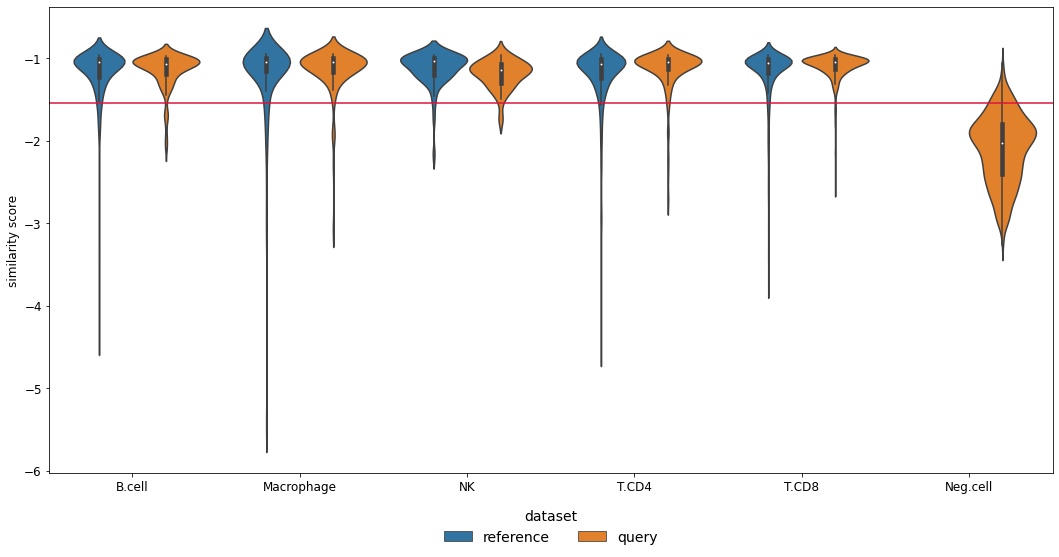

In [10]:
# Figure 6

fig, ax = plt.subplots(figsize=(15,8))
sns.violinplot(x="cell_type", y="score", data=df_melanoma_combine, ax=ax, hue='source', order=unseen_label)
ax.axhline(threshold, color='crimson')
ax.set(xlabel='', ylabel='similarity score')
ax.set_xlabel('')
legend = plt.legend(title='dataset', loc='upper center', bbox_to_anchor=(.5, -0.05), ncol=2, frameon=False,prop={'size': 14} )
plt.tight_layout();

plt.savefig(os.path.join(loc_output, f'similarity_score_{split}_{model_name}_combine.png'), dpi=350, bbox_inches = 'tight', pad_inches=0.1)
plt.savefig(os.path.join(loc_output, f'similarity_score_{split}_{model_name}_combine.pdf'), dpi=350, bbox_inches = 'tight', pad_inches=0.1)
plt.savefig(os.path.join(loc_output, f'similarity_score_{split}_{model_name}_combine.tiff'), dpi=350, bbox_inches = 'tight', pad_inches=0.1)

In [11]:
df_lof_query['threshold'] = 'above'
df_lof_query.loc[df_lof_query['score']<=threshold, 'threshold'] = 'below'
df_lof_query[df_lof_query['cell_type']=='Neg.cell'].groupby('threshold').size()  / len(df_lof_query[df_lof_query['cell_type']=='Neg.cell'])

threshold
above    0.080341
below    0.919659
dtype: float64

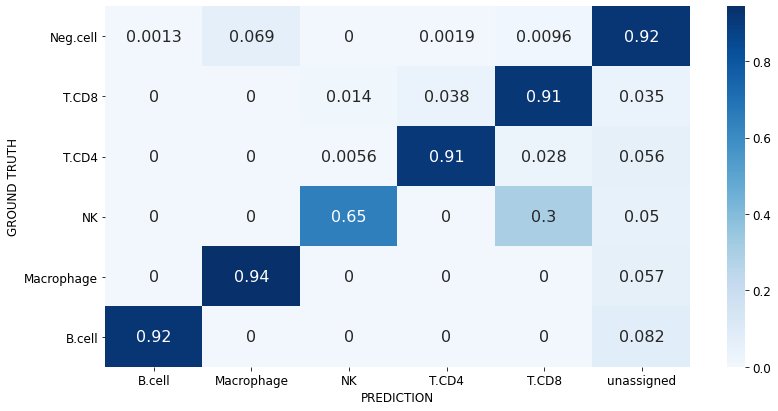

In [12]:
# Figure 5 (top)

# calling unassigned_with_threshold function to assign the cell type as unassigned if the samples are below the threshold
df_pred_truth = src.unassigned_with_threshold(y_with_seen=y_ground_truth_reference
                                   , y_with_unseen=y_ground_truth_query
                                   , X_with_unseen=X_query
                                   , lof_unseen=df_lof_query
                                   , model=model
                                   , threshold=threshold)

df_logo_crosstab = pd.crosstab(df_pred_truth['cell_type'], df_pred_truth['pred'])
df_logo_crosstab = df_logo_crosstab.reindex(list(unseen_label)[::-1])#.sort_index(ascending=False)

src.get_confusion_matrix(df_logo_crosstab)
plt.tight_layout();

plt.savefig(os.path.join(loc_output, f'confusion_matrix_{split}_{model_name}.png'), dpi=350, bbox_inches = 'tight', pad_inches=0.1)
plt.savefig(os.path.join(loc_output, f'confusion_matrix_{split}_{model_name}.pdf'), dpi=350, bbox_inches = 'tight', pad_inches=0.1)
plt.savefig(os.path.join(loc_output, f'confusion_matrix_{split}_{model_name}.tiff'), dpi=350, bbox_inches = 'tight', pad_inches=0.1)

## SCIBET RESULT

In [13]:
scibet_result = pd.read_csv('./data/scibet_result.txt',sep='\t')
scibet_result['prd_with_threshold'] = scibet_result['prd']
scibet_result.loc[scibet_result['c_score']<=0.45, 'prd_with_threshold'] = 'unassigned'

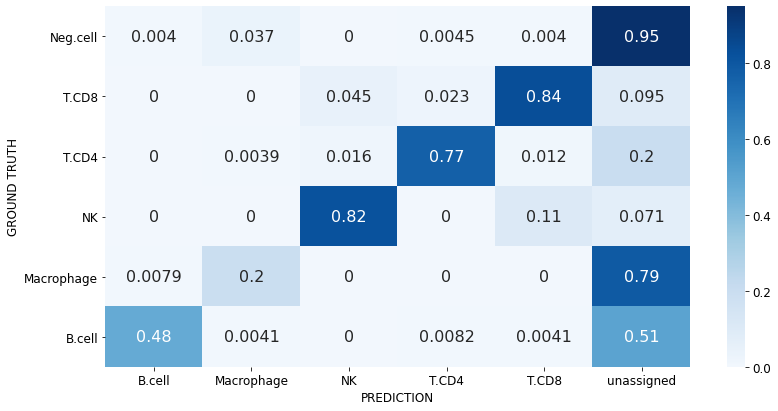

In [14]:
# Figure 5 (bottom)

df_logo_crosstab = pd.crosstab(scibet_result['ori'], scibet_result['prd_with_threshold'])
df_logo_crosstab = df_logo_crosstab.reindex(list(unseen_label)[::-1])#.sort_index(ascending=False)

src.get_confusion_matrix(df_logo_crosstab)
plt.tight_layout();

plt.savefig(os.path.join(loc_output, f'confusion_matrix_scibet.png'), dpi=350, bbox_inches = 'tight')
plt.savefig(os.path.join(loc_output, f'confusion_matrix_scibet.pdf'), dpi=350, bbox_inches = 'tight')
plt.savefig(os.path.join(loc_output, f'confusion_matrix_scibet.tiff'), dpi=350, bbox_inches = 'tight')